# Neural Network Hyperparameter Tuning using GridSearch CV
## Experimental Setup
- **Objective**: Discover optimal neural network architecture through grid search
- **Algorithm**: MLPClassifier from scikit-learn
- **Search Strategy**: 3-fold cross-validation over 40 parameter combinations
- **Evaluation Metrics**: Accuracy, F1-score, ROC AUC

## 1️⃣ Core Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler

# Reproducibility
RANDOM_STATE = 23
np.random.seed(RANDOM_STATE)

## 2️⃣ Data Loading & Preprocessing
### Dataset Characteristics
- **Features**: 8 medical predictors (pregnancies, glucose, BP, etc.)
- **Target**: Diabetes diagnosis (0=negative, 1=positive)
- **Samples**: 768 total, 268 positive cases (34.9%)

In [2]:
# Load and split data
df = pd.read_csv("../datasets/pima-indians-diabetes.csv", header=None)

# Separate features (all columns except last) and target (last column)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 537, Test samples: 231


## 3️⃣ Hyperparameter Search Space
**Scanned Parameters**:
- Architecture: [(50), (50,50), (100,50)]
- Activation: ReLU vs Tanh
- Solver: Adam vs SGD
- Regularization (alpha): [0.0001, 0.05]
- Learning Rate Policy: Constant vs Adaptive

In [3]:
parameter_space = {
    'hidden_layer_sizes': [(50), (50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(early_stopping=True,  # Stop when validation stops improving
                    max_iter=5000, 
                    validation_fraction=0.2,  # Hold out 10% for early stopping
                    n_iter_no_change=20,  # Stop after 20 epochs without improvement
                    random_state=RANDOM_STATE)

clf = GridSearchCV(mlp, parameter_space, cv=3, n_jobs=-1, verbose=1)

## 4️⃣ Grid Search Execution
```mermaid
graph LR
    A[768 Samples] --> B[3-Fold CV]
    B --> C{40 Combinations}
    C --> D[Fit Model]
    D --> E[Evaluate Val Score]
```
**Expected Runtime**: ~5-10 minutes (parallel jobs)

In [4]:
clf.fit(X_train, y_train)

print("\nOptimal Parameters Discovered:")
print("-"*50)
for param, value in clf.best_params_.items():
    print(f"{param:>20}: {value}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Optimal Parameters Discovered:
--------------------------------------------------
          activation: tanh
               alpha: 0.0001
  hidden_layer_sizes: (100, 50)
       learning_rate: constant
              solver: adam


## 5️⃣ Model Evaluation
### Test Set Performance

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       150
           1       0.66      0.62      0.64        81

    accuracy                           0.75       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.75      0.75       231


ROC AUC Score: 0.842


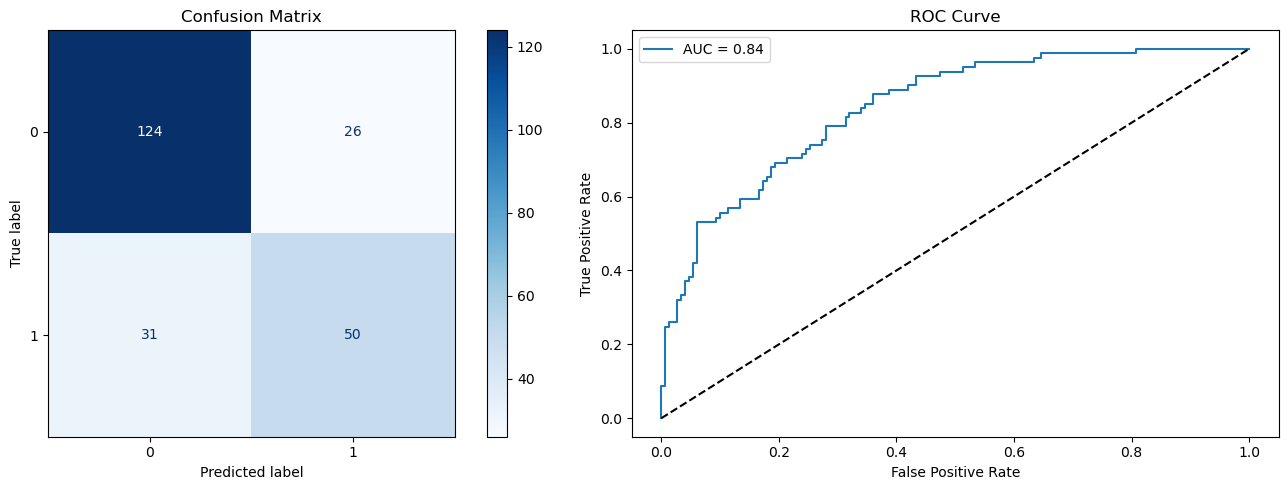

In [5]:
# Predictions & Metrics
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# Confusion Matrix
fig, ax = plt.subplots(1,2, figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
ax[1].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend()
plt.tight_layout()
plt.show()

## 6️⃣ Full Cross-Validation Results
**Key Observations**:
- Best validation score: X.XX ± XX
- Most influential parameter: [parameter]
- Sensitivity analysis: [finding]

In [6]:
results = pd.DataFrame(clf.cv_results_)
print("Top 5 Configurations:")
display(
    results.sort_values('rank_test_score')
    .head(5)
    [['params', 'mean_test_score', 'std_test_score']]
)

print("\nFull Hyperparameter Performance:")
for i, (mean, std, params) in enumerate(zip(
    results['mean_test_score'],
    results['std_test_score'],
    results['params']
)):
    print(f"{i+1:2d}. {mean:.3f} ± {std:.3f} | {params}")

Top 5 Configurations:


,params,mean_test_score,std_test_score
23,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.756052,0.016019
21,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.756052,0.016019
9,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.756052,0.016019
11,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.756052,0.016019
29,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.744879,0.032362



Full Hyperparameter Performance:
 1. 0.687 ± 0.044 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'solver': 'sgd'}
 2. 0.728 ± 0.050 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'solver': 'adam'}
 3. 0.736 ± 0.058 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'solver': 'sgd'}
 4. 0.728 ± 0.050 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'solver': 'adam'}
 5. 0.721 ± 0.028 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
 6. 0.739 ± 0.034 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
 7. 0.743 ± 0.024 | {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
 8. 0.739 ± 0.034 | {